<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

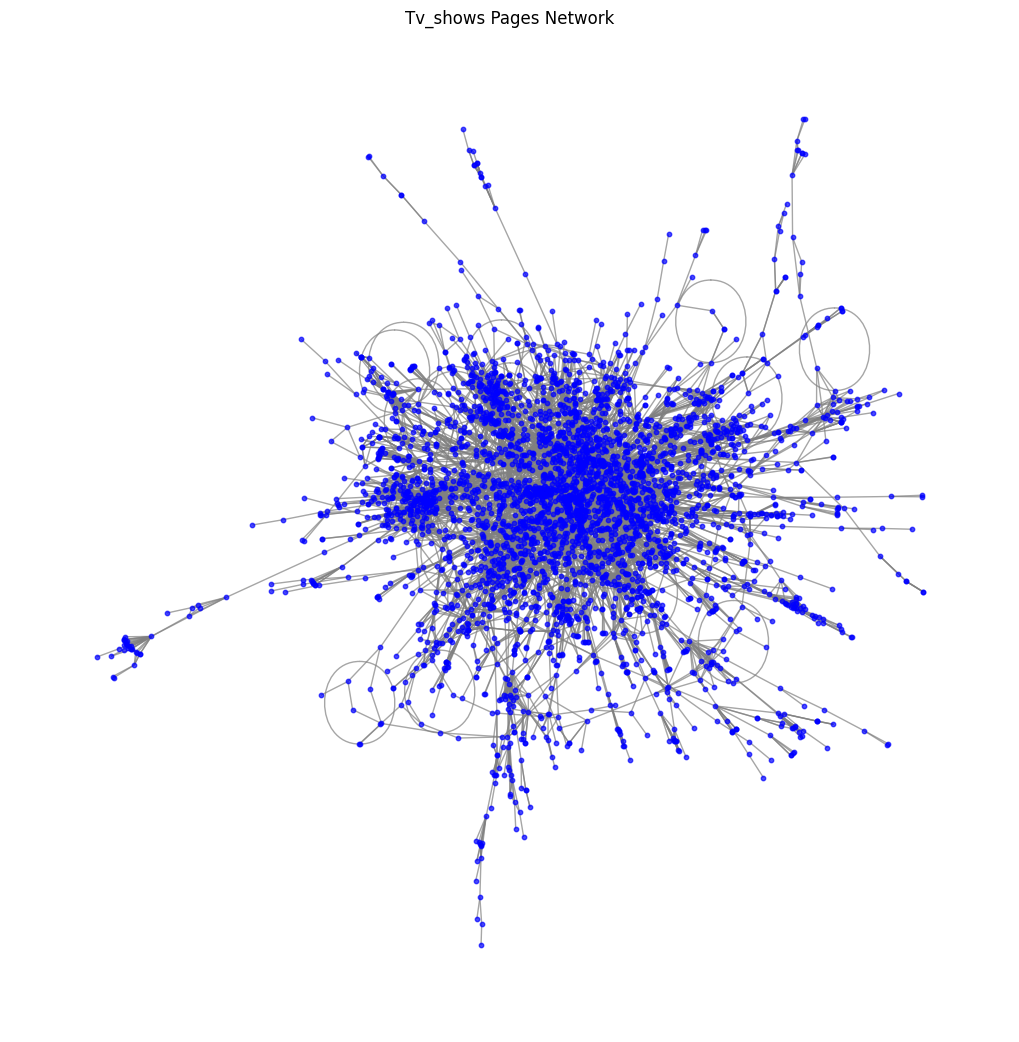

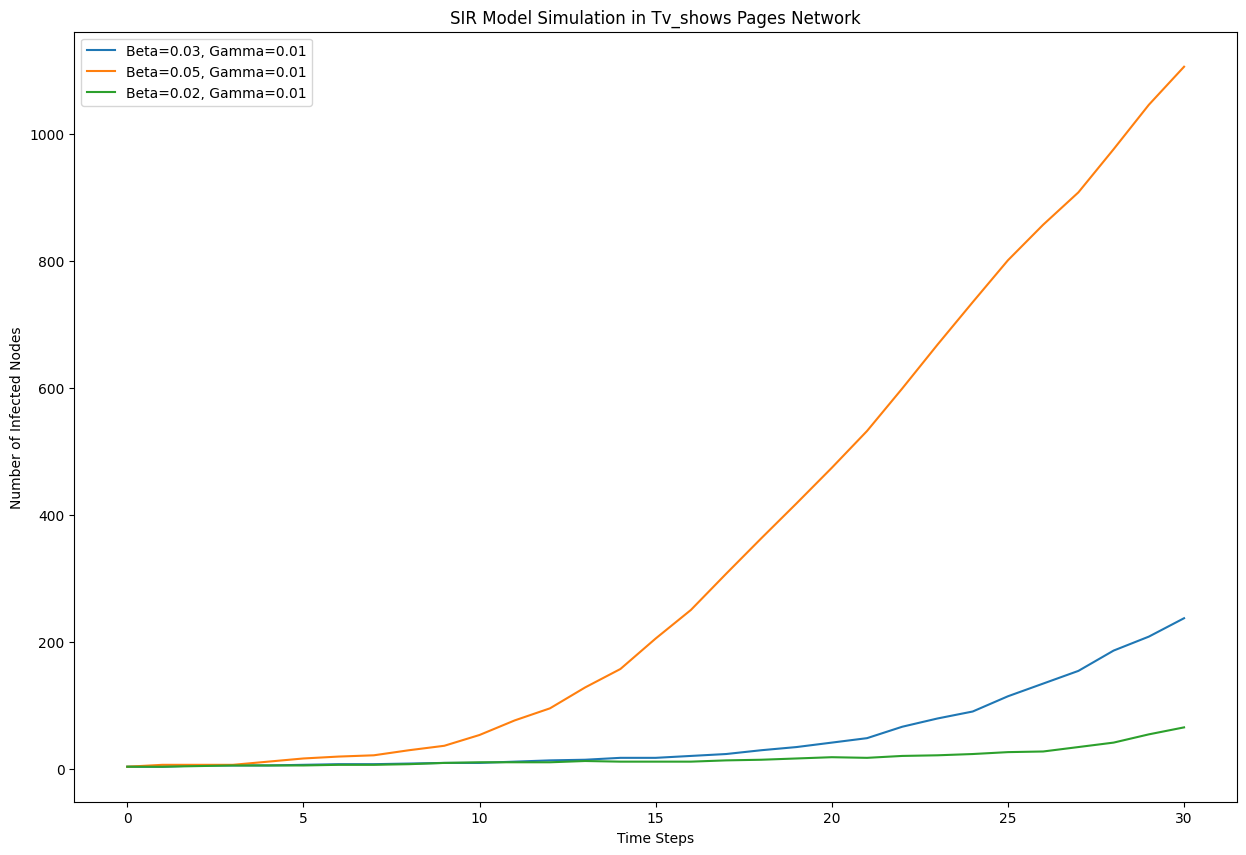

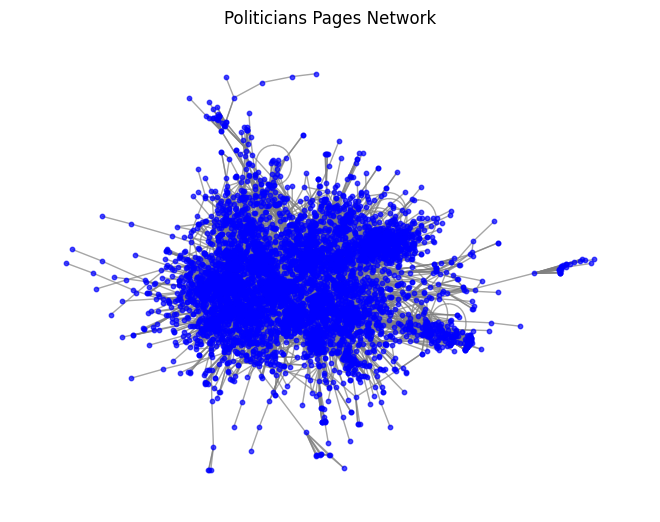

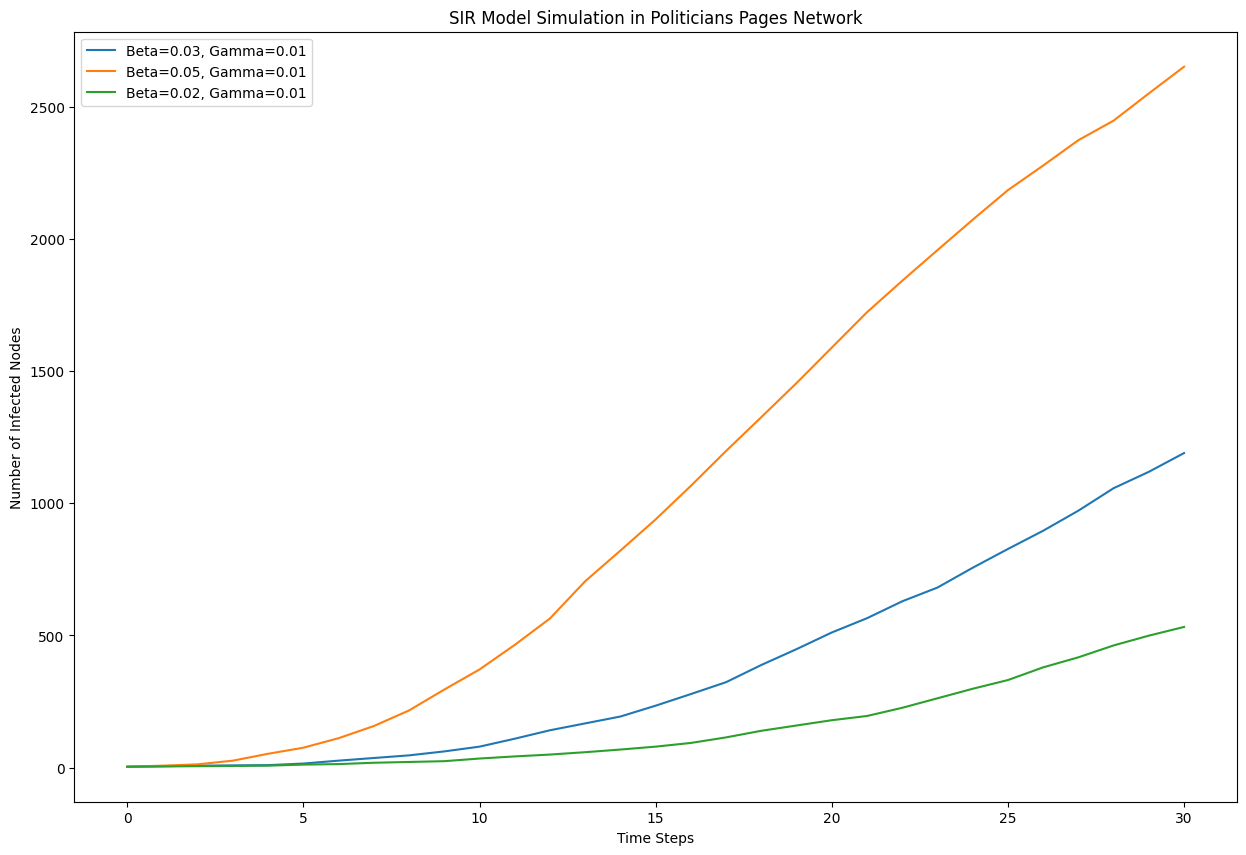

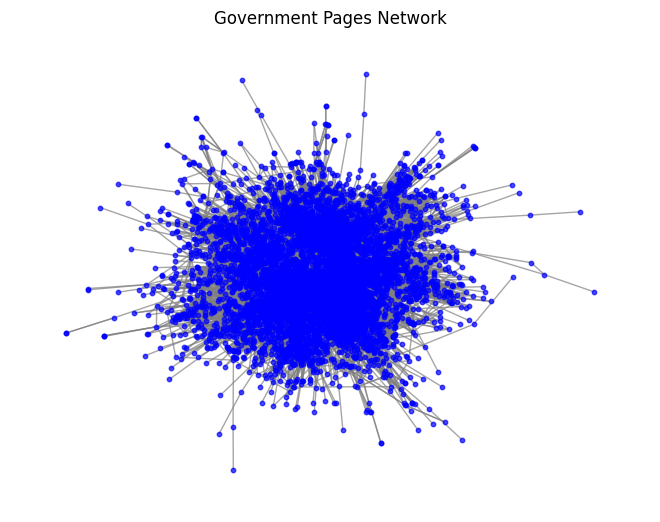

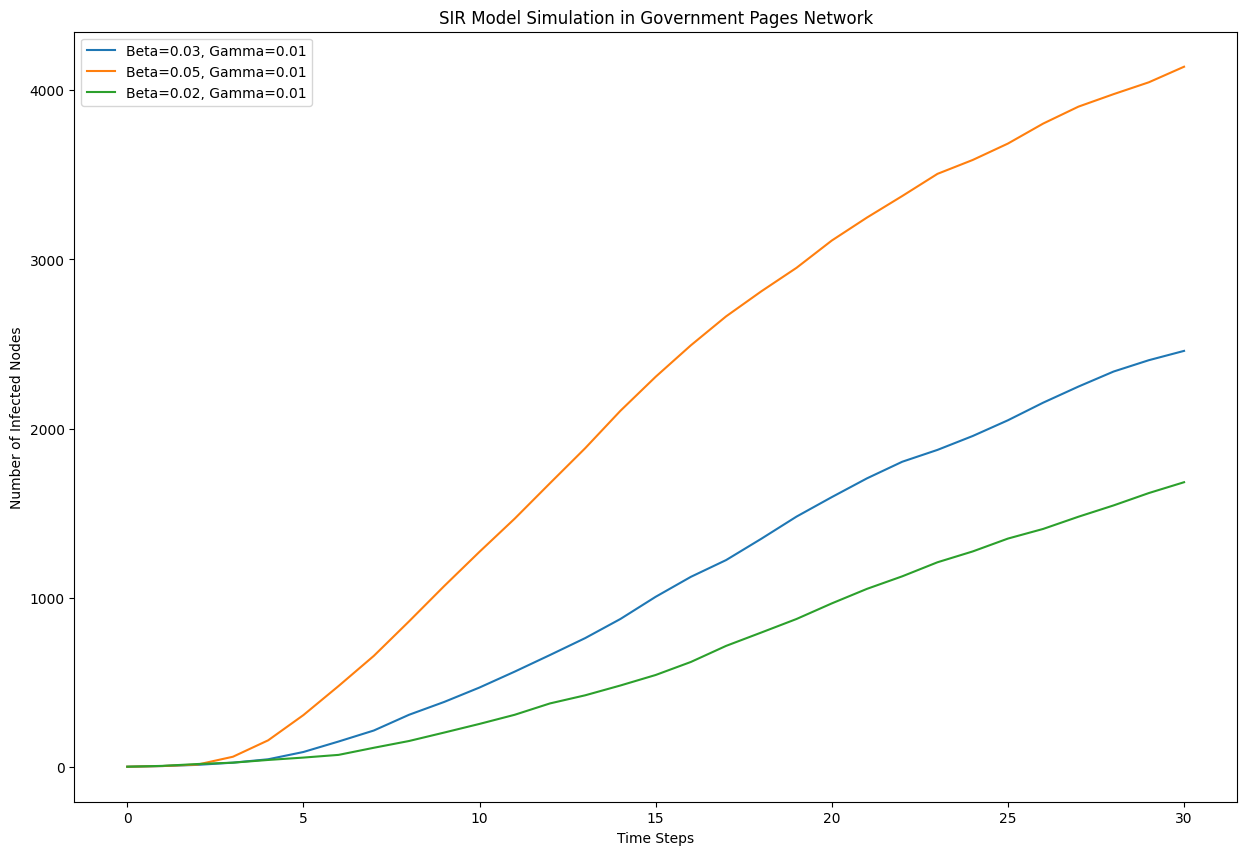

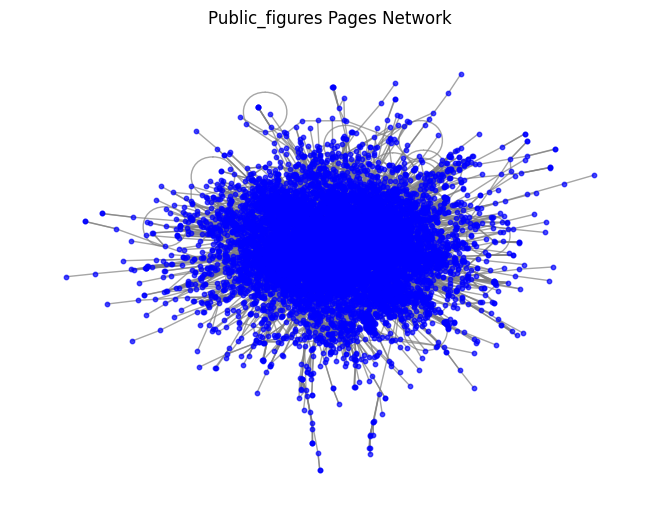

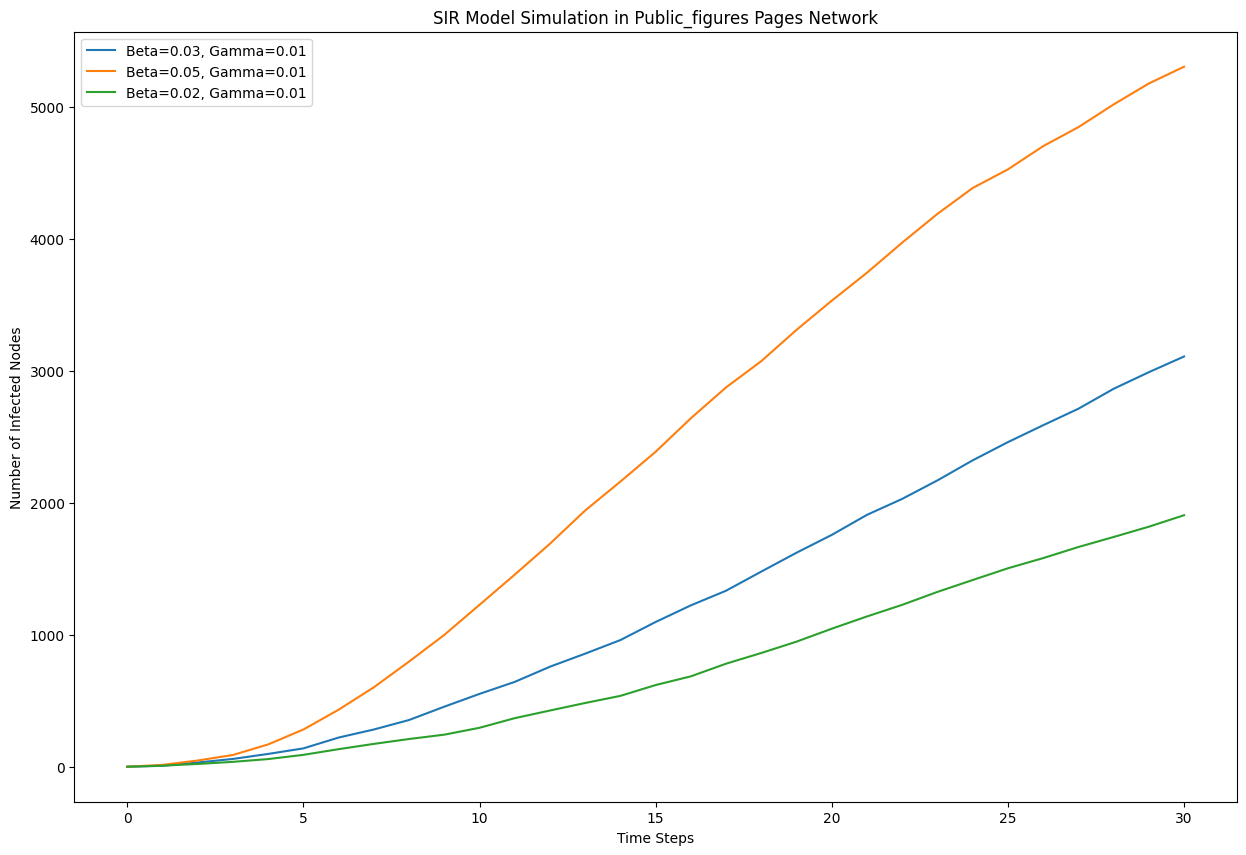

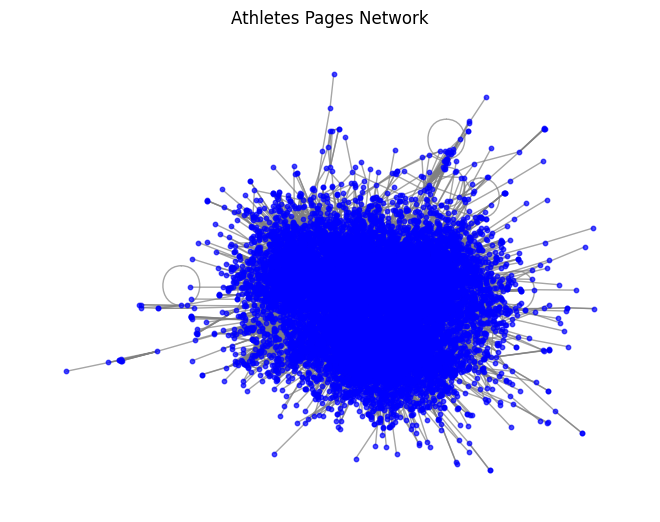

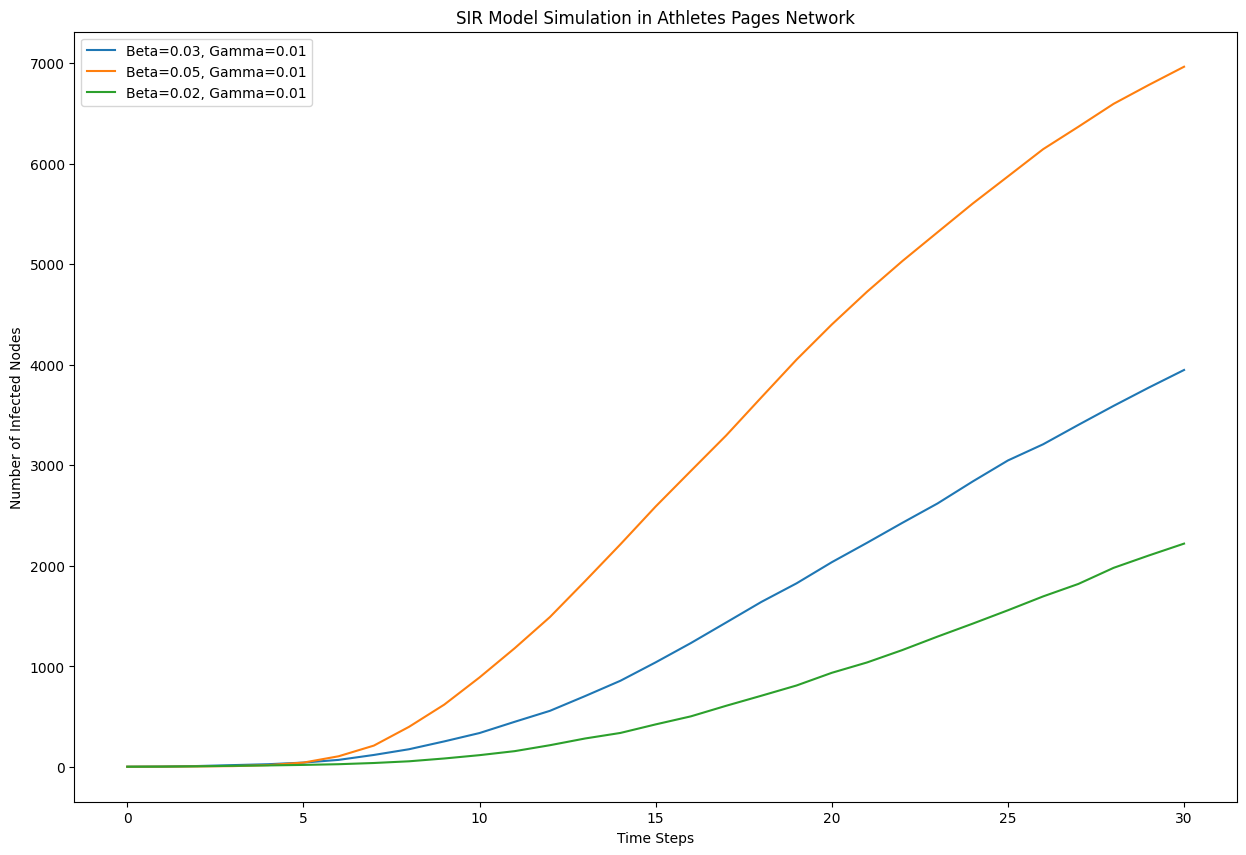

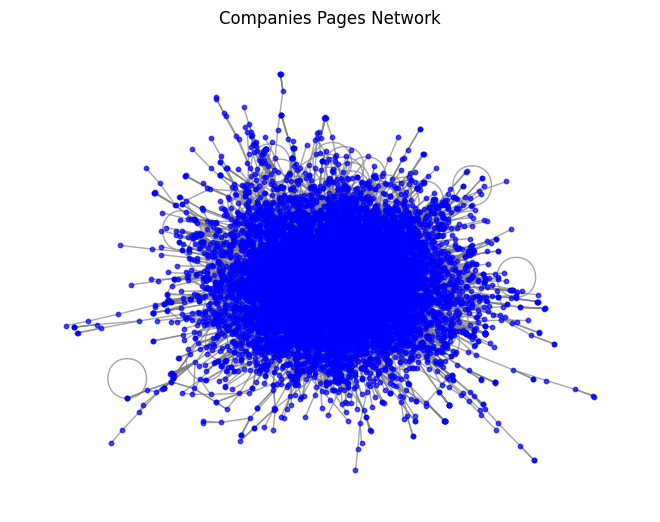

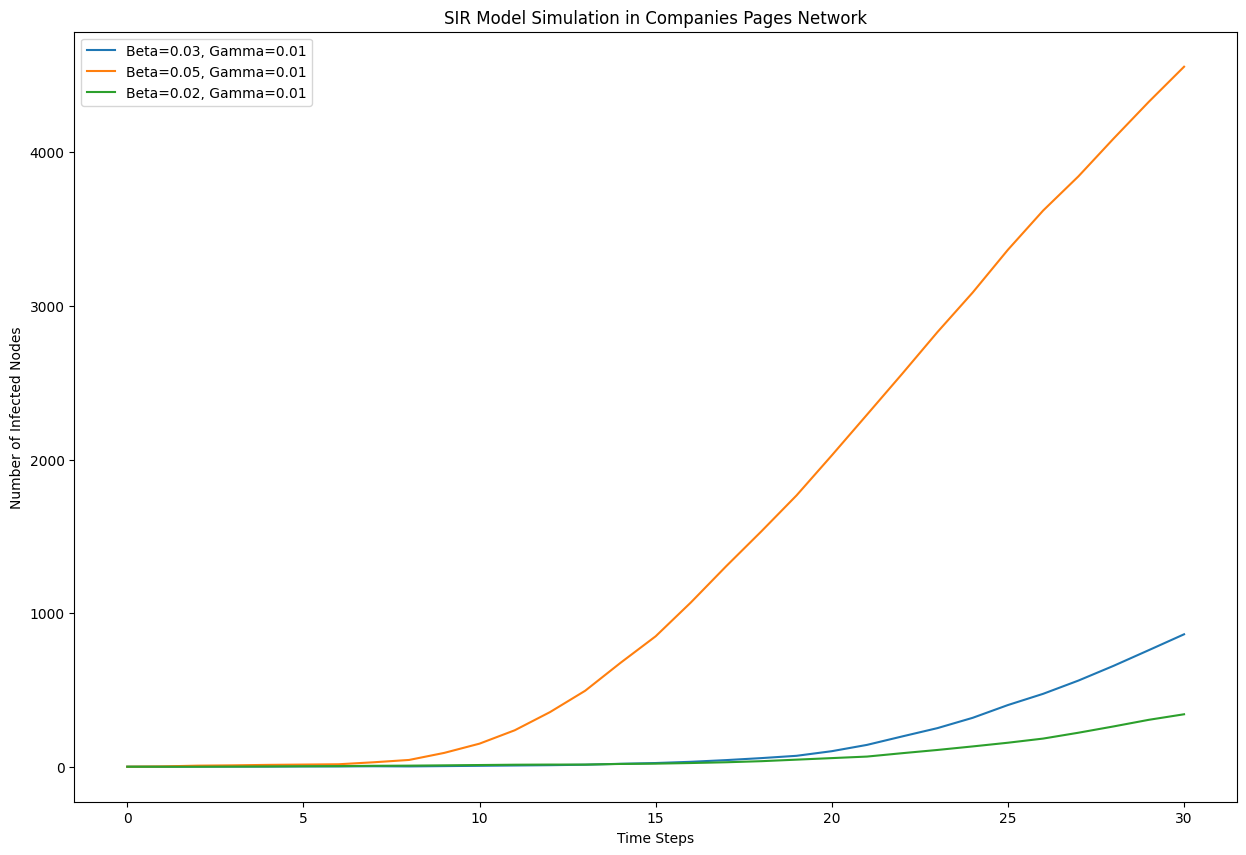

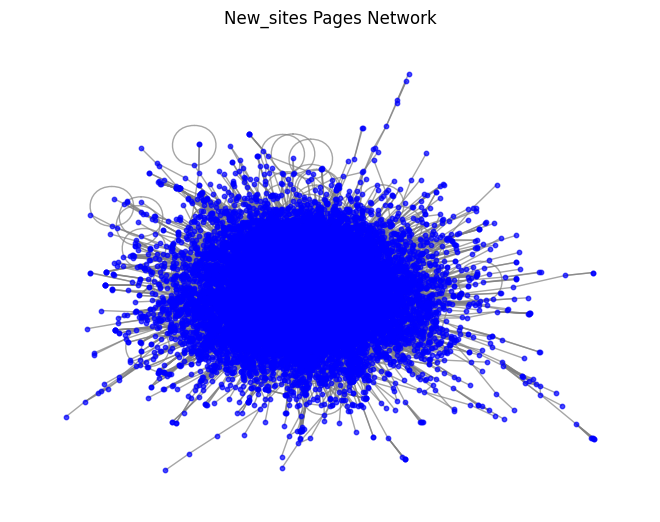

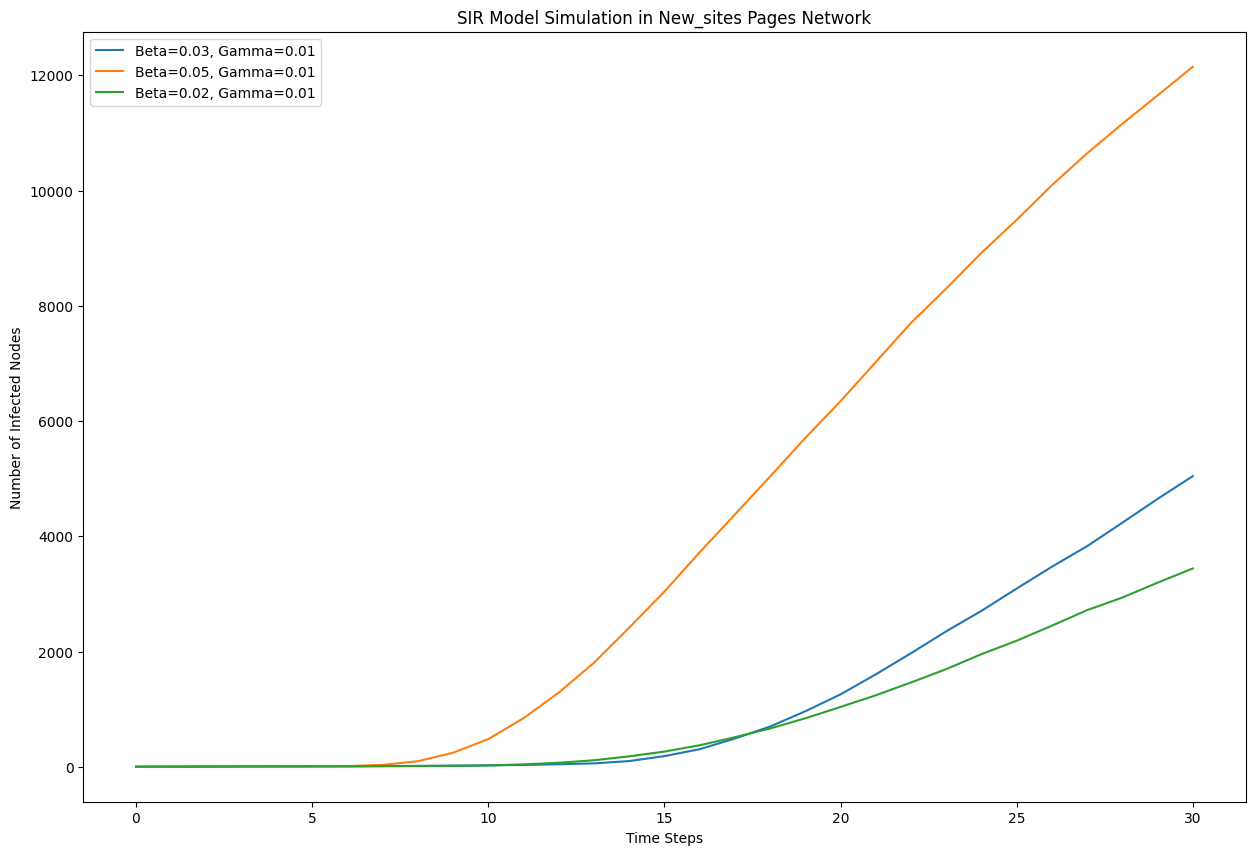

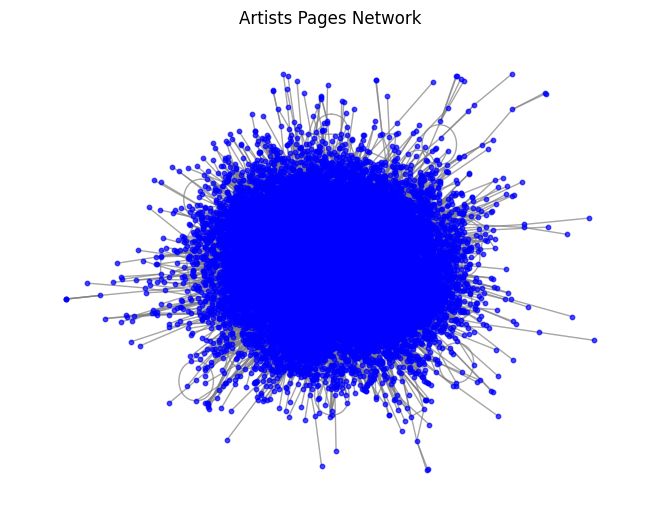

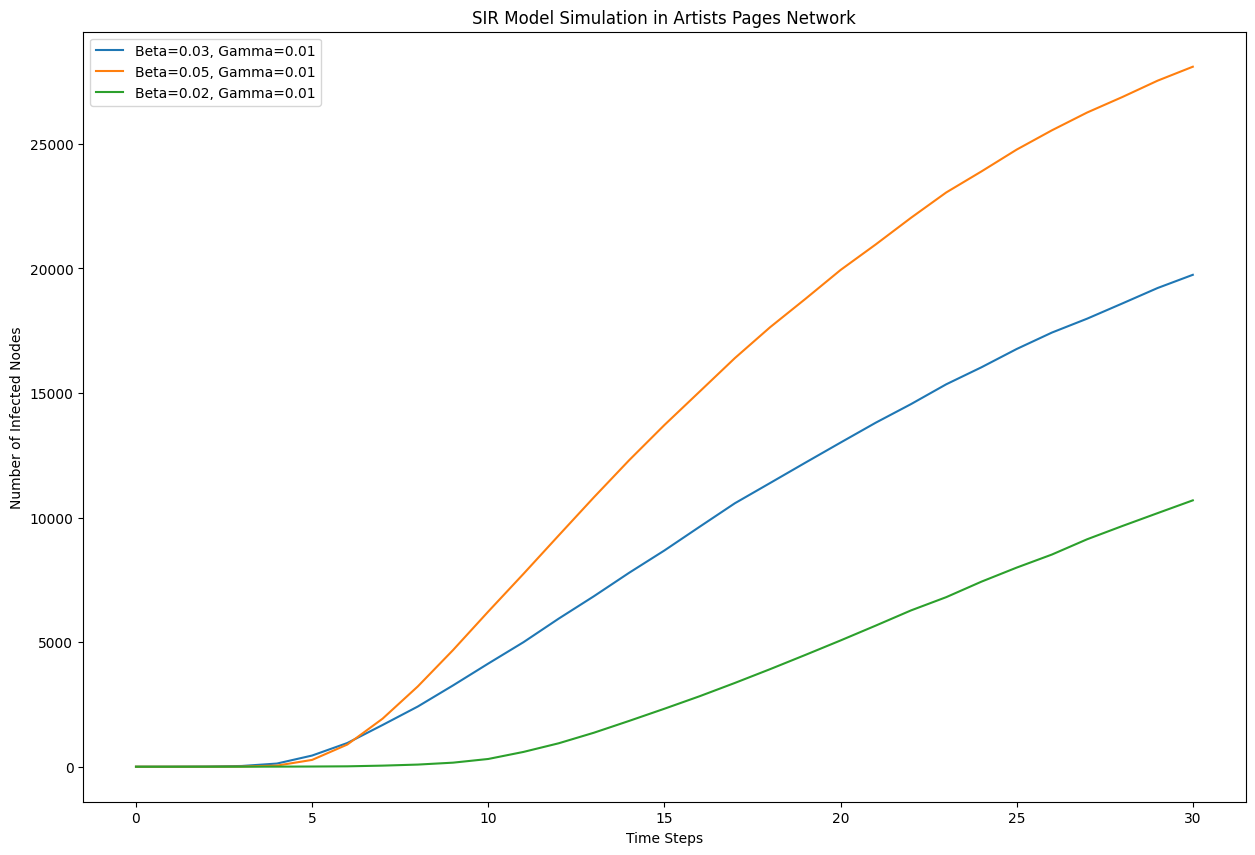

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor

# file path
data_folder = '../data/facebook_gemsec/'
datasets = {
    'government': 'government_edges.csv',
    'new_sites': 'new_sites_edges.csv',
    'athletes': 'athletes_edges.csv',
    'public_figures': 'public_figure_edges.csv',
    'tv_shows': 'tvshow_edges.csv',
    'politicians': 'politician_edges.csv',
    'artists': 'artist_edges.csv',
    'companies': 'company_edges.csv'
}

# load the csv and create graphs
def load_graph(category, file_name):
    file_path = os.path.join(data_folder, file_name)
    df = pd.read_csv(file_path)
    G = nx.from_pandas_edgelist(df, source='node_1', target='node_2')
    return category, G

graphs = {}
with ThreadPoolExecutor() as executor:
    future_to_category = {executor.submit(load_graph, category, file_name): category for category, file_name in datasets.items()}
    for future in future_to_category:
        category, G = future.result()
        graphs[category] = G

# define plotgraph
def plot_graph(G, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=10, edge_color='gray', node_color='blue', alpha=0.7)
    plt.title(title)
    plt.show()

# defien simulate SIR
def simulate_SIR(G, beta, gamma, initial_infected, steps=30):
    S = set(G.nodes())  # Susceptible
    I = set(initial_infected)  # Infected
    R = set()  # Recovered

    susceptible_counts = [len(S)]
    infected_counts = [len(I)]
    recovered_counts = [len(R)]

    for _ in range(steps):
        new_infected = set()
        new_recovered = set()

        for node in I:
            neighbors = set(G.neighbors(node))
            new_infected.update(neighbors.intersection(S))
            if np.random.rand() < gamma:
                new_recovered.add(node)

        new_infected = {node for node in new_infected if np.random.rand() < beta}

        S.difference_update(new_infected)
        I.update(new_infected)
        I.difference_update(new_recovered)
        R.update(new_recovered)

        susceptible_counts.append(len(S))
        infected_counts.append(len(I))
        recovered_counts.append(len(R))

    return susceptible_counts, infected_counts, recovered_counts

# initiate the node
initial_nodes = [0, 1, 2]

# different parameters
parameters = [
    {'beta': 0.03, 'gamma': 0.01, 'label': 'Beta=0.03, Gamma=0.01'},
    {'beta': 0.05, 'gamma': 0.01, 'label': 'Beta=0.05, Gamma=0.01'},
    {'beta': 0.02, 'gamma': 0.01, 'label': 'Beta=0.02, Gamma=0.01'}
]

# define process category
def process_category(category, G):
    plot_graph(G, f'{category.capitalize()} Pages Network')
    plt.figure(figsize=(15, 10))
    for params in parameters:
        _, I, _ = simulate_SIR(G, params['beta'], params['gamma'], initial_nodes)
        plt.plot(I, label=params['label'])
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Infected Nodes')
    plt.title(f'SIR Model Simulation in {category.capitalize()} Pages Network')
    plt.legend()
    plt.show()

with ThreadPoolExecutor() as executor:
    future_to_category = {executor.submit(process_category, category, G): category for category, G in graphs.items()}
    for future in future_to_category:
        future.result()


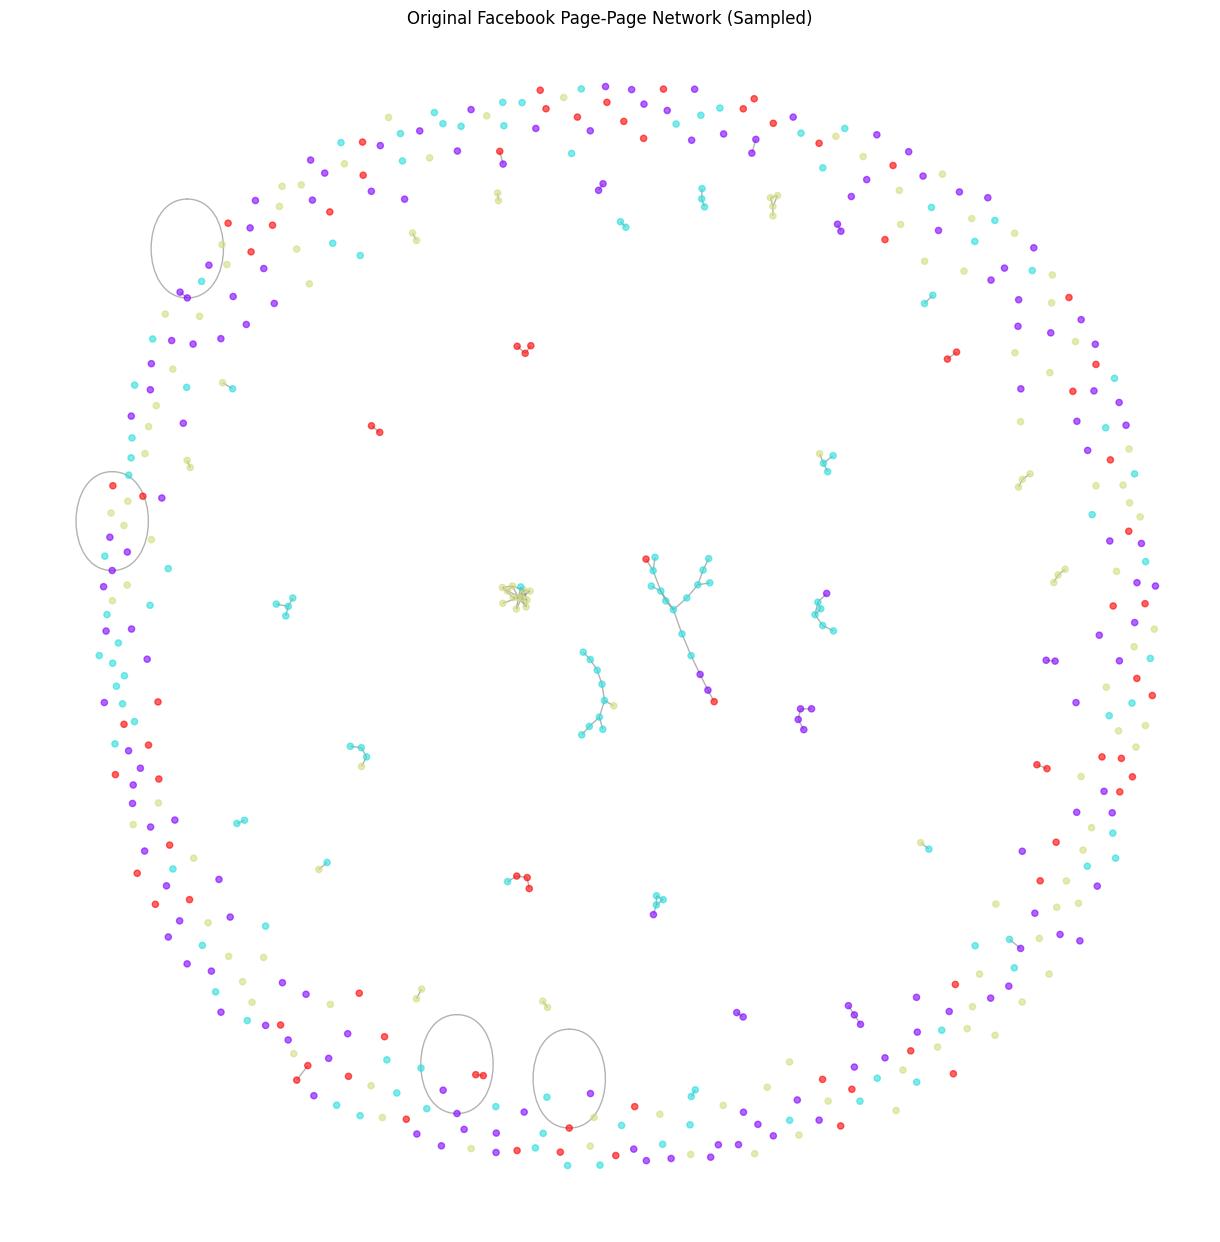

e:\programfiles\py3.11\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


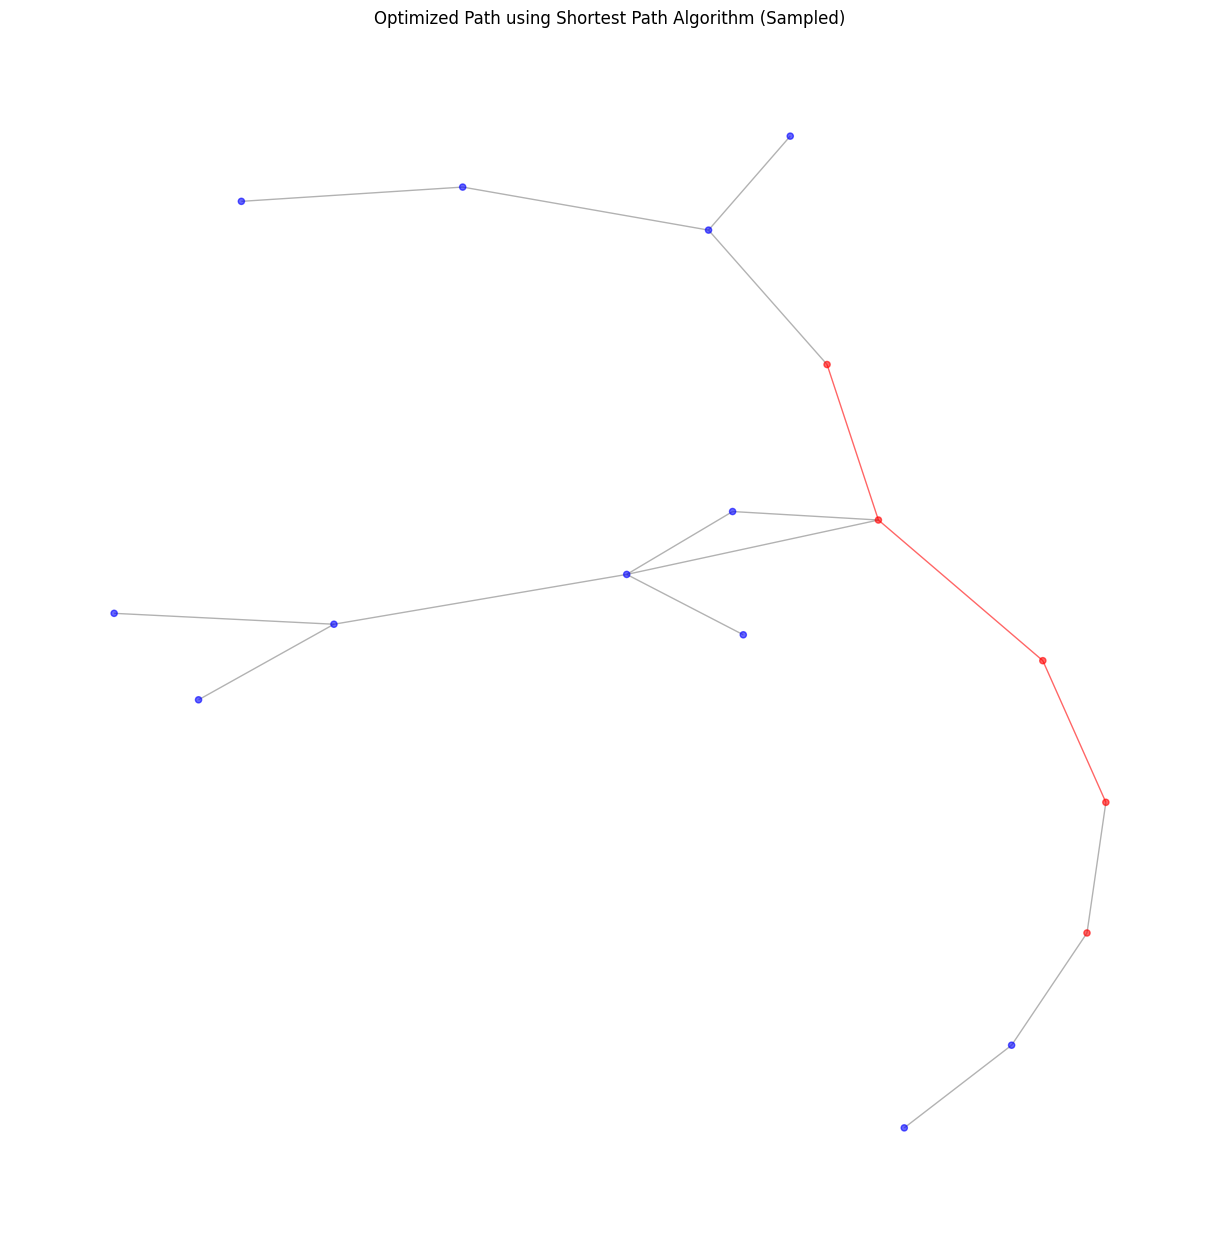

Maximum Flow from node 4453 to node 4678: 1


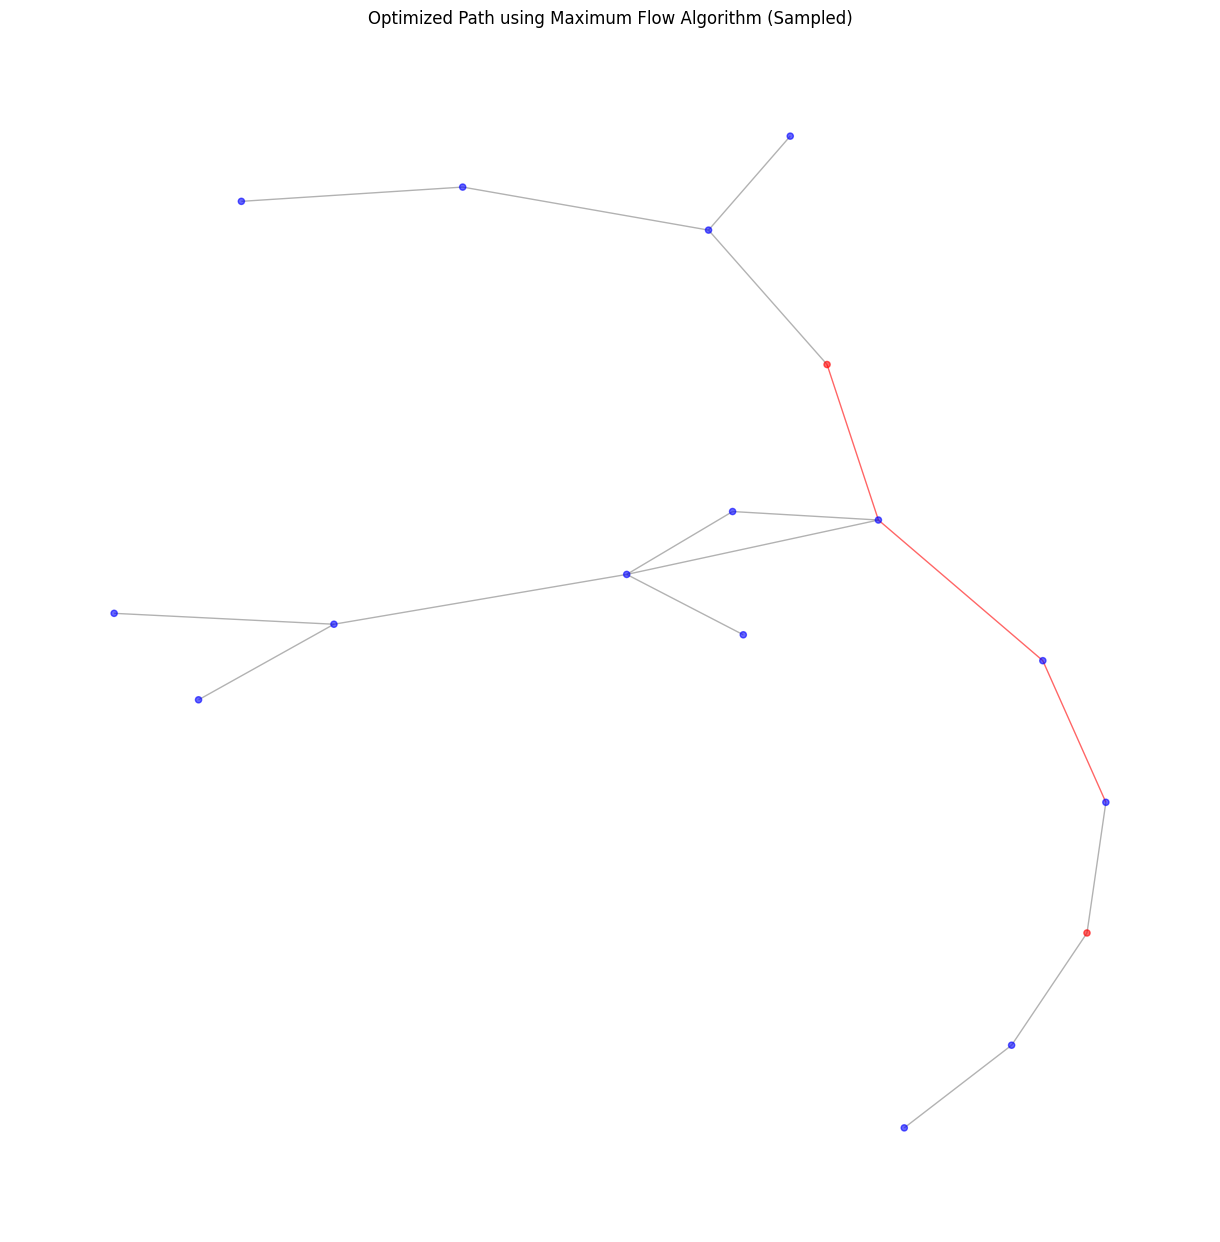

Shortest Path Length: 5
Maximum Flow Value: 1
Original Network Diameter (Sampled): 9
Shortest Path Length after Optimization: 5


In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import json
import random
from sklearn.preprocessing import LabelEncoder

# file path
data_folder = '../data/facebook_large/'
edge_file = os.path.join(data_folder, 'musae_facebook_edges.csv')
feature_file = os.path.join(data_folder, 'musae_facebook_features.json')
target_file = os.path.join(data_folder, 'musae_facebook_target.csv')

# load 
edges = pd.read_csv(edge_file)
with open(feature_file) as f:
    features = json.load(f)
targets = pd.read_csv(target_file)

# create graph
G = nx.from_pandas_edgelist(edges, source='id_1', target='id_2')
for u, v, d in G.edges(data=True):
    d['capacity'] = 1

# sample node
random.seed(42)
sampled_nodes = random.sample(list(G.nodes), 500)
G = G.subgraph(sampled_nodes)

# add feature
for node, feature_list in features.items():
    if int(node) in G.nodes:
        G.nodes[int(node)]['features'] = feature_list

for idx, row in targets.iterrows():
    if int(row['id']) in G.nodes:
        G.nodes[int(row['id'])]['label'] = row['page_type']

# transit to number
label_encoder = LabelEncoder()
labels = [G.nodes[node].get('label', 'unknown') for node in G.nodes]
encoded_labels = label_encoder.fit_transform(labels)

def plot_graph(G, title, node_color):
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=20, node_color=node_color, edge_color='gray', alpha=0.6, cmap=plt.cm.rainbow)
    plt.title(title)
    plt.show()

plot_graph(G, 'Original Facebook Page-Page Network (Sampled)', encoded_labels)

def shortest_path_optimization(G, source, target):
    try:
        return nx.shortest_path(G, source=source, target=target)
    except nx.NetworkXNoPath:
        return None

def max_flow_optimization(G, source, target):
    try:
        flow_value, _ = nx.maximum_flow(G, source, target, capacity='capacity')
        return flow_value
    except nx.NetworkXNoPath:
        return None

def visualize_optimized_path(G, source, target, path, title):
    if path is None:
        print(f"No path found between {source} and {target}.")
        return

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    node_color = ['red' if n in path else 'blue' for n in G.nodes]
    edge_color = ['red' if (u, v) in zip(path[:-1], path[1:]) else 'gray' for u, v in G.edges]
    nx.draw(G, pos, node_size=20, node_color=node_color, edge_color=edge_color, alpha=0.6, cmap=plt.cm.rainbow)
    plt.title(title)
    plt.show()

def find_connected_nodes(G):
    nodes = list(G.nodes)
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if nx.has_path(G, nodes[i], nodes[j]):
                return nodes[i], nodes[j]
    return None, None

# get the largest component
largest_component = max(nx.connected_components(G), key=len)
H = G.subgraph(largest_component)

source_node, target_node = find_connected_nodes(H)
if source_node is None or target_node is None:
    raise ValueError("No connected nodes found in the largest connected component.")

# spo
shortest_path = shortest_path_optimization(H, source_node, target_node)
visualize_optimized_path(H, source_node, target_node, shortest_path, 'Optimized Path using Shortest Path Algorithm (Sampled)')

# mfo
max_flow = max_flow_optimization(H, source_node, target_node)
print(f'Maximum Flow from node {source_node} to node {target_node}: {max_flow}')

def visualize_max_flow_path(G, source, target, title):
    flow_value, flow_dict = nx.maximum_flow(G, source, target, capacity='capacity')
    edges_in_flow = [(u, v) for u, adj in flow_dict.items() for v, flow in adj.items() if flow > 0]

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    node_color = ['red' if n == source or n == target else 'blue' for n in G.nodes]
    edge_color = ['red' if (u, v) in edges_in_flow else 'gray' for u, v in G.edges]
    nx.draw(G, pos, node_size=20, node_color=node_color, edge_color=edge_color, alpha=0.6, cmap=plt.cm.rainbow)
    plt.title(title)
    plt.show()

visualize_max_flow_path(H, source_node, target_node, 'Optimized Path using Maximum Flow Algorithm (Sampled)')

# compare
def compare_strategies(G, source, target):
    sp_path = shortest_path_optimization(G, source, target)
    sp_length = len(sp_path) if sp_path else None
    mf_value = max_flow_optimization(G, source, target)
    return sp_length, mf_value

sp_length, mf_value = compare_strategies(H, source_node, target_node)
print(f'Shortest Path Length: {sp_length}')
print(f'Maximum Flow Value: {mf_value}')
print(f'Original Network Diameter (Sampled): {nx.diameter(H)}')
print(f'Shortest Path Length after Optimization: {sp_length}')